<a href="https://colab.research.google.com/github/DaniyalK03/PML/blob/main/LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Machine Learning for Physicists
## Week 6 Exercise
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import matplotlib.style
import matplotlib as mpl

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=150



In [ ]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2


In [ ]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [ ]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


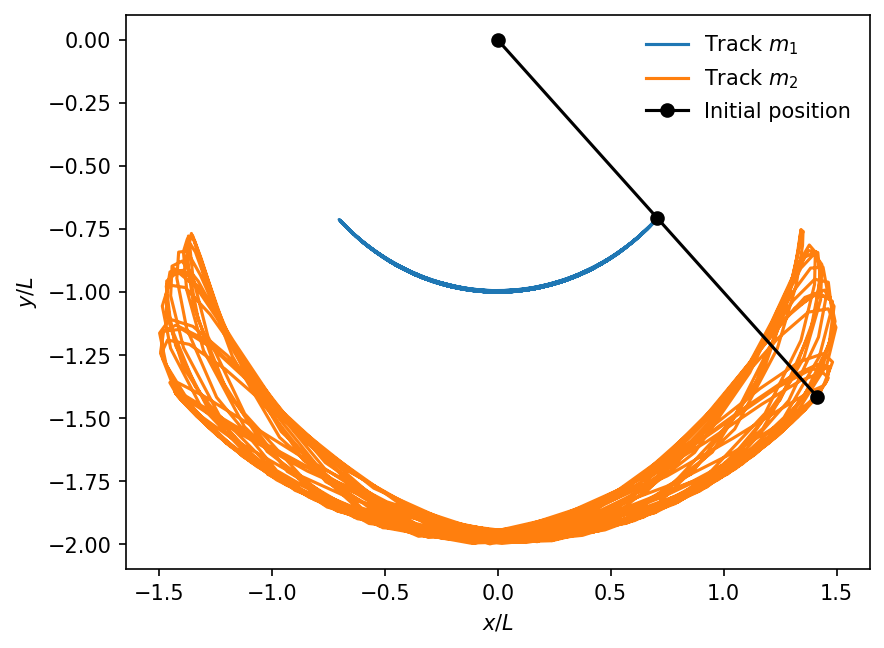

In [ ]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$.
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



# Coursework E

**Submission by SN: 21015796**

##Introduction

The following notebook is submitted coursework E for PHAS0056.

This notebook compares the accuracy of the predictions of the positions of a double pendulum as made by a Long Short Term Memory Recurrent Neural Network.

The first initial conditions are detailed below for masses m1 and m2 with an offset of 20 initially used. The cost of this is compared to the training steps from a training sample of the first 240 position steps.

This is tested against the remaining positions and the predicted positions of the pendulum are compared with the observed positions. This is then repeated for various offsets up to 100 and the final cost achieved vs offset is recorded.

The second initial conditions differ slightly however the same batchsize is used to predict the positions for a more chaotic system and is also tested across a range of offsets up to an offset of 100. The final cost achieved vs offset size is also recorded.

A function is defined to train a model using only information of the cartesian positions of m2.

The following code is adapted and structured similar to example notebook [1].

*Bibliography*

[1] R. Nichol, "Week6_Prediction.ipynb", UCL, PHAS:0056, 2024

In [ ]:
#Same backend from [1]

#Import tqdm for progress bar
from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Setting up a LSTM RNN
model=keras.models.Sequential()
model.add(keras.layers.LSTM(128,input_shape=(None, 4),return_sequences=False)) # LSTM layer with 128 neurons and input and output of 4 corresponding to each position x1, y1, x2, y2.
model.add(keras.layers.Dense(4,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 68612 (268.02 KB)
Trainable params: 68612 (268.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Function adapted from [1]

windowsize=20 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict


#This function splits up a 1-d array x into a series of overlapping windows
#The return is a tuple of the array of input windows and target (label) windows
def shapeArray(x,windowsize,offset):
    xInput= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel= np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)



In [ ]:

x1inputs, x1labels = shapeArray(x1, windowsize, offset)
y1inputs, y1labels = shapeArray(y1, windowsize, offset)
x2inputs, x2labels = shapeArray(x2, windowsize, offset)
y2inputs, y2labels = shapeArray(y2, windowsize, offset)

inputs_comb = np.stack((x1inputs, y1inputs, x2inputs, y2inputs), axis=2) # Combining all 4 inputs for RNN

labels_comb = np.stack((x1labels, y1labels, x2labels, y2labels),axis=2) # Combining all 4 labels


In [ ]:
# An arbitrary value of up to the 240th value has been chosen so there is a sufficiently large training sample and a sufficiently large testing sample.

train_inputs = inputs_comb[0:240,:,:]
test_inputs = inputs_comb[241:-1,:,:]

train_labels = labels_comb[0:240,:,:]
test_labels = labels_comb[241:-1,:,:]


Epoch 1/100
6/6 - 7s - loss: 0.8024 - val_loss: 0.3250 - 7s/epoch - 1s/step
Epoch 2/100
6/6 - 0s - loss: 0.2538 - val_loss: 0.1884 - 397ms/epoch - 66ms/step
Epoch 3/100
6/6 - 1s - loss: 0.1122 - val_loss: 0.0667 - 515ms/epoch - 86ms/step
Epoch 4/100
6/6 - 0s - loss: 0.0631 - val_loss: 0.0663 - 254ms/epoch - 42ms/step
Epoch 5/100
6/6 - 0s - loss: 0.0556 - val_loss: 0.0525 - 323ms/epoch - 54ms/step
Epoch 6/100
6/6 - 0s - loss: 0.0414 - val_loss: 0.0422 - 353ms/epoch - 59ms/step
Epoch 7/100
6/6 - 0s - loss: 0.0371 - val_loss: 0.0389 - 249ms/epoch - 41ms/step
Epoch 8/100
6/6 - 0s - loss: 0.0344 - val_loss: 0.0343 - 304ms/epoch - 51ms/step
Epoch 9/100
6/6 - 0s - loss: 0.0290 - val_loss: 0.0319 - 285ms/epoch - 48ms/step
Epoch 10/100
6/6 - 0s - loss: 0.0278 - val_loss: 0.0287 - 330ms/epoch - 55ms/step
Epoch 11/100
6/6 - 0s - loss: 0.0235 - val_loss: 0.0233 - 277ms/epoch - 46ms/step
Epoch 12/100
6/6 - 0s - loss: 0.0209 - val_loss: 0.0210 - 243ms/epoch - 40ms/step
Epoch 13/100
6/6 - 0s - loss: 

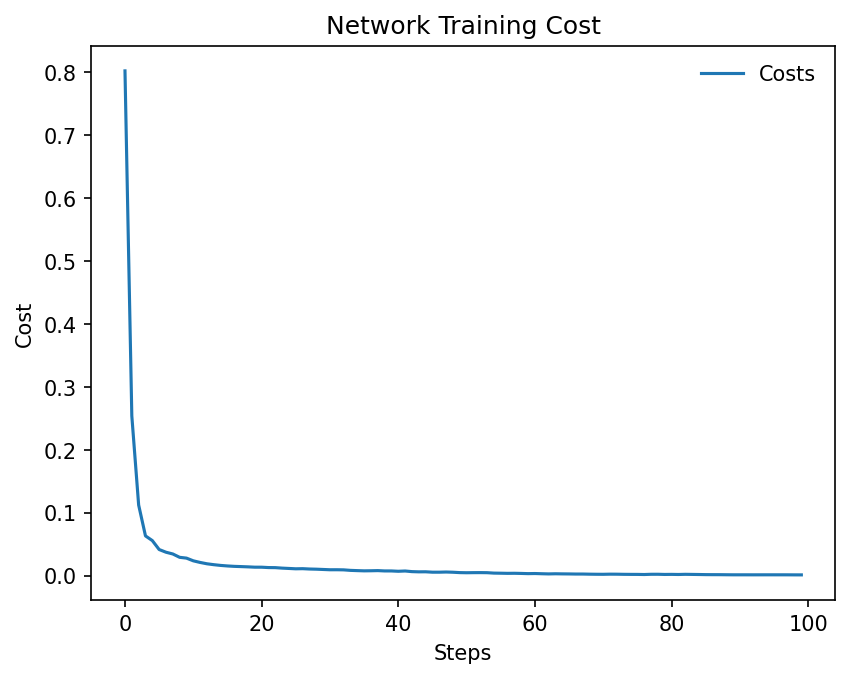

In [ ]:
# Plotting below adapted from example notebook [1].
steps=100  #Number of training steps

history = model.fit(train_inputs, train_labels[:,-1,:], epochs=100, validation_split = 0.2, verbose=2) # Train the network
costs = history.history['loss']



#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

The cost value converges to order of 10^-4 hence the training of the RNN reaches high accuracies.

In [ ]:
predict_pos = model.predict(test_inputs) # Predicting cartesian positions using test inputs

# Extracting cartesian values using splicing
predict_x1 = predict_pos[:,0]
predict_y1 = predict_pos[:,1]
predict_x2 = predict_pos[:,2]
predict_y2 = predict_pos[:,3]


7/7 [==============================] - 0s 8ms/step


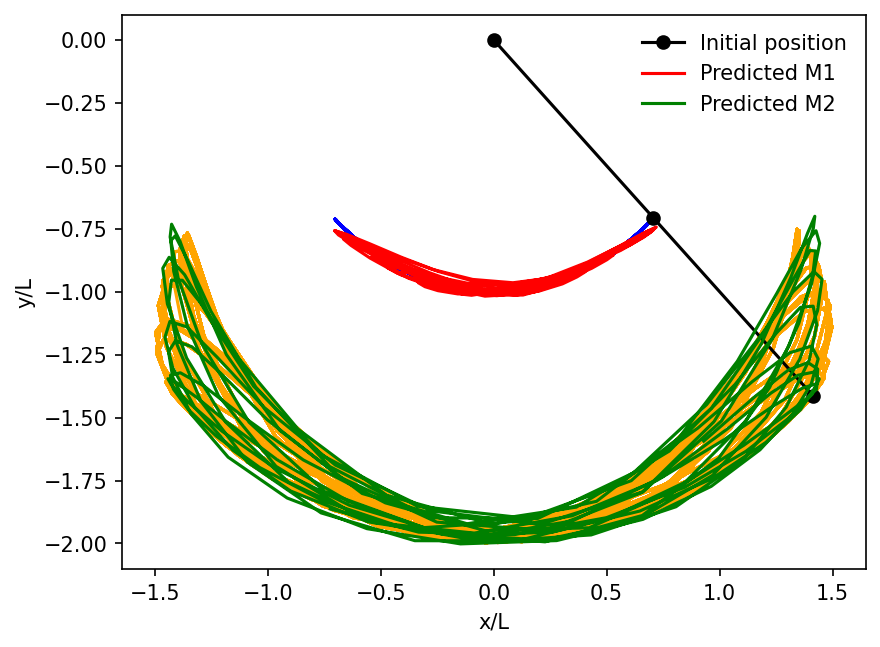

In [ ]:

plt.plot(x1inputs, y1inputs, "-", color = "b") # Actual position of m1
plt.plot(x2inputs, y2inputs, "-", color = "orange") # Actual position of m2
plt.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k') # Initial position
plt.plot(predict_x1, predict_y1, "-", label = "Predicted M1", color = "r") # Predicted m1 positions
plt.plot(predict_x2, predict_y2, "-", label = "Predicted M2", color = "g") # Predicted m2 positions
plt.xlabel("x/L")
plt.ylabel("y/L")

plt.legend(loc="best")

This model has quite accurately predicted the positions of m1 and m2 with the given initial conditions.


In [ ]:
def train_model(x1, y1, x2, y2, windowsize, offset):
  """
  Inputs: Cartesian coordinates: Takes in the positions of m1 and m2
          windowsize = variable (20 used)
          offset = variable (20 used)

  Outputs:model = Model used that is trained on training inputs
          test_inputs = Testing inputs used for predictions
          costs = cost values used for plotting
          inputs = reshaped inputs for pendulum position values
  """

  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(128,input_shape=(None, 4),return_sequences=False)) # LSTM layer with 20 neurons
  model.add(keras.layers.Dense(4,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam')


  x1inputs, x1labels = shapeArray(x1, windowsize, offset)
  y1inputs, y1labels = shapeArray(y1, windowsize, offset)
  x2inputs, x2labels = shapeArray(x2, windowsize, offset)
  y2inputs, y2labels = shapeArray(y2, windowsize, offset)

  inputs_comb = np.stack((x1inputs, y1inputs, x2inputs, y2inputs), axis=2)

  labels_comb = np.stack((x1labels, y1labels, x2labels, y2labels),axis=2)


  train_inputs = inputs_comb[0:240,:,:]
  test_inputs = inputs_comb[241:-1,:,:]

  train_labels = labels_comb[0:240,:,:]
  test_labels = labels_comb[241:-1,:,:]


  steps=100  #Number of training steps

  history = model.fit(train_inputs, train_labels[:,-1,:], epochs=100, validation_split = 0.2, verbose=2) # Train the network
  costs = history.history['loss']

  return model, test_inputs, costs, x1inputs, y1inputs, x2inputs, y2inputs

Epoch 1/100
6/6 - 2s - loss: 0.7238 - val_loss: 0.2661 - 2s/epoch - 377ms/step
Epoch 2/100
6/6 - 0s - loss: 0.2028 - val_loss: 0.1433 - 144ms/epoch - 24ms/step
Epoch 3/100
6/6 - 0s - loss: 0.0735 - val_loss: 0.0583 - 138ms/epoch - 23ms/step
Epoch 4/100
6/6 - 0s - loss: 0.0632 - val_loss: 0.0617 - 152ms/epoch - 25ms/step
Epoch 5/100
6/6 - 0s - loss: 0.0503 - val_loss: 0.0451 - 157ms/epoch - 26ms/step
Epoch 6/100
6/6 - 0s - loss: 0.0391 - val_loss: 0.0433 - 147ms/epoch - 24ms/step
Epoch 7/100
6/6 - 0s - loss: 0.0373 - val_loss: 0.0384 - 149ms/epoch - 25ms/step
Epoch 8/100
6/6 - 0s - loss: 0.0332 - val_loss: 0.0341 - 136ms/epoch - 23ms/step
Epoch 9/100
6/6 - 0s - loss: 0.0298 - val_loss: 0.0320 - 145ms/epoch - 24ms/step
Epoch 10/100
6/6 - 0s - loss: 0.0276 - val_loss: 0.0280 - 151ms/epoch - 25ms/step
Epoch 11/100
6/6 - 0s - loss: 0.0246 - val_loss: 0.0247 - 145ms/epoch - 24ms/step
Epoch 12/100
6/6 - 0s - loss: 0.0221 - val_loss: 0.0222 - 161ms/epoch - 27ms/step
Epoch 13/100
6/6 - 0s - los

Text(0.5, 1.0, 'Cost of models trained on different offsets')

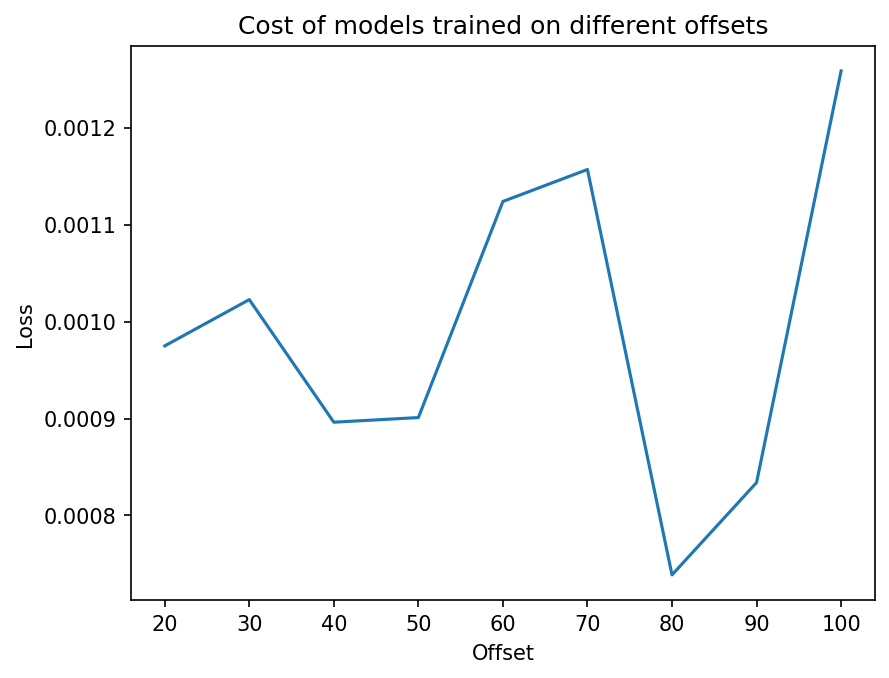

In [ ]:
offset_array = np.linspace(20,100,9) # Offsets at every interval of 10 starting from 20 to 100
#print(offset_array)
costs_array = np.zeros(len(offset_array)) # Initialise empty array for costs

# Calculating final costs for each offset
for i in range(len(offset_array)):
  model1, test_inputs1, costs1, x1inputs1, y1inputs1, x2inputs1, y2inputs1 = train_model(x1, y1, x2, y2, 20, int(offset_array[i]))
  predict_pos1 = model1.predict(test_inputs1)
  predict1_x1 = predict_pos1[:,0]
  predict1_x2 = predict_pos1[:,1]
  predict1_y1 = predict_pos1[:,2]
  predict1_y2 = predict_pos1[:,3]
  #print(costs1)
  costs_array[i] = costs1[-1]

# Plotting and labelling final cost vs offset
plt.plot(offset_array, costs_array)
plt.xlabel("Offset")
plt.ylabel("Loss")
plt.title("Cost of models trained on different offsets")


Validation loss should increase as offsets increase as it becomes increasingly harder for the model to predict further along the sequence.

In [ ]:
def init_con_solve(L1, L2, m1, m2, g, z0, tmax, dt):

  """
  Inputs: L = Length
          m = Mass
          g = gravitational field strength
          z0 = initial conditions used
          tmax = variable (50 used)
          dt = time step (0.1 used)
  Outputs:Cartesian Coordinates = The position solutions to the initial value double pendulum problem
  """
  t = np.arange(0, tmax+dt, dt)

  # Solve initial value problem
  ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
  z=ret.y
  #print(np.shape(z))

  # Extract result
  theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
  x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

  return x1, y1, x2, y2

In [ ]:
new_z0 = z0=[np.pi/2,0,np.pi/2,0] # New Initial conditions
new_x1, new_y1, new_x2, new_y2 = init_con_solve(1,1,3,1,9.81, new_z0, 50, 0.1) # New position values

In [ ]:
model2, test_inputs2, costs2, x1inputs2, y1inputs2, x2inputs2, y2inputs2 = train_model(new_x1, new_y1, new_x2, new_y2, 20, 20) # Define new trained model to be used


Epoch 1/100
6/6 - 2s - loss: 0.6879 - val_loss: 0.3990 - 2s/epoch - 388ms/step
Epoch 2/100
6/6 - 0s - loss: 0.4954 - val_loss: 0.3319 - 146ms/epoch - 24ms/step
Epoch 3/100
6/6 - 0s - loss: 0.4426 - val_loss: 0.2931 - 149ms/epoch - 25ms/step
Epoch 4/100
6/6 - 0s - loss: 0.4162 - val_loss: 0.2796 - 151ms/epoch - 25ms/step
Epoch 5/100
6/6 - 0s - loss: 0.4005 - val_loss: 0.2698 - 159ms/epoch - 26ms/step
Epoch 6/100
6/6 - 0s - loss: 0.3904 - val_loss: 0.2594 - 164ms/epoch - 27ms/step
Epoch 7/100
6/6 - 0s - loss: 0.3721 - val_loss: 0.2551 - 158ms/epoch - 26ms/step
Epoch 8/100
6/6 - 0s - loss: 0.3541 - val_loss: 0.2538 - 149ms/epoch - 25ms/step
Epoch 9/100
6/6 - 0s - loss: 0.3360 - val_loss: 0.2537 - 153ms/epoch - 26ms/step
Epoch 10/100
6/6 - 0s - loss: 0.3104 - val_loss: 0.2631 - 155ms/epoch - 26ms/step
Epoch 11/100
6/6 - 0s - loss: 0.2873 - val_loss: 0.2706 - 149ms/epoch - 25ms/step
Epoch 12/100
6/6 - 0s - loss: 0.2786 - val_loss: 0.2791 - 147ms/epoch - 24ms/step
Epoch 13/100
6/6 - 0s - los

7/7 [==============================] - 0s 8ms/step


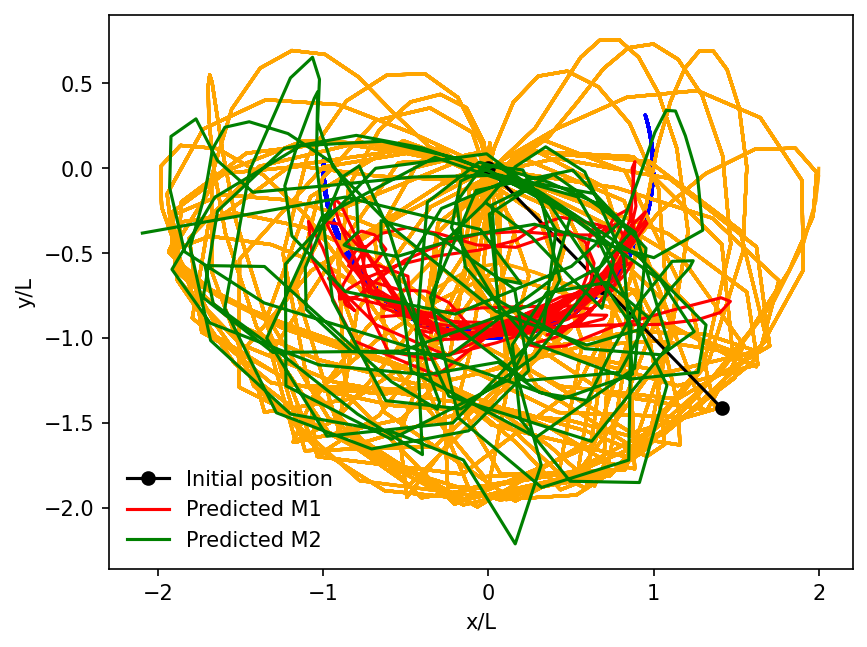

In [ ]:
# Prediction of positions for double pendulum positions with new inital conditons
predict_pos2 = model2.predict(test_inputs2)

predict2_x1 = predict_pos2[:,0]
predict2_y1 = predict_pos2[:,1]
predict2_x2 = predict_pos2[:,2]
predict2_y2 = predict_pos2[:,3]

# Plotting and Labelling
plt.plot(x1inputs2, y1inputs2, "-", color = "b") # Actual m1 positions
plt.plot(x2inputs2, y2inputs2, "-", color = "orange") # Actual m2 positions
plt.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k') # Initial positions
plt.plot(predict2_x1, predict2_y1, "-", label = "Predicted M1", color = "r") # Predicted m1 positions
plt.plot(predict2_x2, predict2_y2, "-", label = "Predicted M2", color = "g") # Predicted m2 positions
plt.xlabel("x/L")
plt.ylabel("y/L")

plt.legend(loc="best")

The initial conditions used here have created a much more chaotic system that is harder to predict.

Epoch 1/100
6/6 - 2s - loss: 0.6568 - val_loss: 0.3888 - 2s/epoch - 392ms/step
Epoch 2/100
6/6 - 0s - loss: 0.4852 - val_loss: 0.3482 - 157ms/epoch - 26ms/step
Epoch 3/100
6/6 - 0s - loss: 0.4409 - val_loss: 0.3259 - 154ms/epoch - 26ms/step
Epoch 4/100
6/6 - 0s - loss: 0.4217 - val_loss: 0.3050 - 170ms/epoch - 28ms/step
Epoch 5/100
6/6 - 0s - loss: 0.4026 - val_loss: 0.2750 - 159ms/epoch - 27ms/step
Epoch 6/100
6/6 - 0s - loss: 0.3871 - val_loss: 0.2646 - 156ms/epoch - 26ms/step
Epoch 7/100
6/6 - 0s - loss: 0.3692 - val_loss: 0.2715 - 158ms/epoch - 26ms/step
Epoch 8/100
6/6 - 0s - loss: 0.3532 - val_loss: 0.2693 - 148ms/epoch - 25ms/step
Epoch 9/100
6/6 - 0s - loss: 0.3270 - val_loss: 0.2759 - 154ms/epoch - 26ms/step
Epoch 10/100
6/6 - 0s - loss: 0.3059 - val_loss: 0.3155 - 170ms/epoch - 28ms/step
Epoch 11/100
6/6 - 0s - loss: 0.2785 - val_loss: 0.3273 - 160ms/epoch - 27ms/step
Epoch 12/100
6/6 - 0s - loss: 0.2702 - val_loss: 0.3706 - 151ms/epoch - 25ms/step
Epoch 13/100
6/6 - 0s - los

Text(0.5, 1.0, 'Cost of models trained on different offsets')

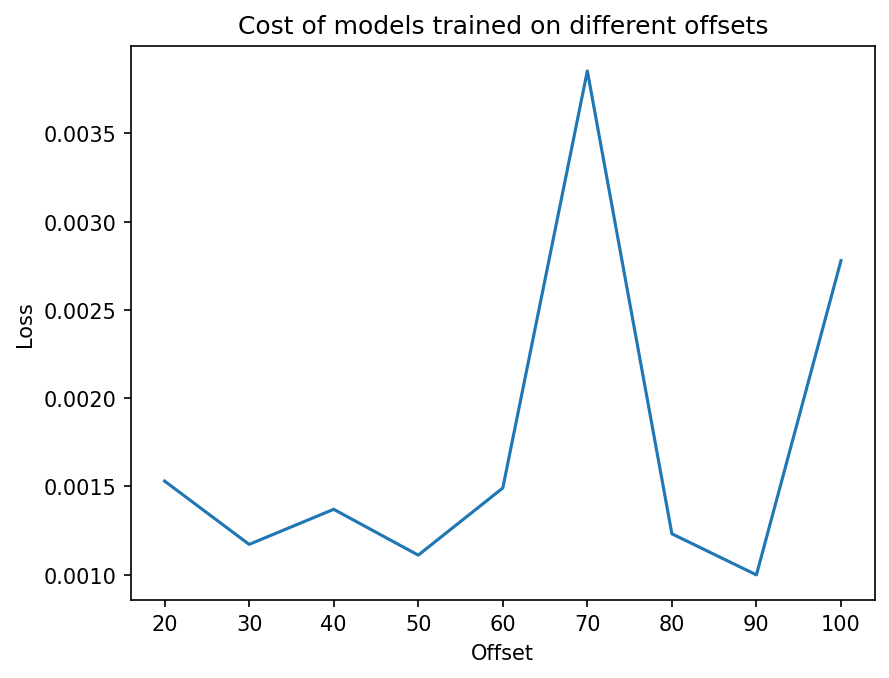

In [ ]:
offset_array2 = np.linspace(20,100,9)
#print(offset_array)
costs_array2 = np.zeros(len(offset_array2))

for i in range(len(offset_array2)):
  model3, test_inputs3, costs3, x1inputs3, y1inputs3, x2inputs3, y2inputs3 = train_model(new_x1, new_y1, new_x2, new_y2, 20, int(offset_array2[i]))
  predict_pos3 = model3.predict(test_inputs3)
  predict3_x1 = predict_pos3[:,0]
  predict3_x2 = predict_pos3[:,1]
  predict3_y1 = predict_pos3[:,2]
  predict3_y2 = predict_pos3[:,3]
  #print(costs1)
  costs_array2[i] = costs3[-1]

plt.plot(offset_array2, costs_array2)
plt.xlabel("Offset")
plt.ylabel("Loss")
plt.title("Cost of models trained on different offsets")

No general trend observed as system is chaotic enough where the trained model has difficulty predicting positions accurately regardless of offset.

In [ ]:
# Attempt at creating training model function using only positions of m2

def train_model_m2(x2, y2, windowsize, offset):


  model=keras.models.Sequential()
  model.add(keras.layers.LSTM(128,input_shape=(None, 2),return_sequences=False)) # LSTM layer with 128 neurons now only using 2 inputs and outputs as only positions of m2 are used
  model.add(keras.layers.Dense(2,activation="linear"))
  model.compile(loss='mean_squared_error',optimizer='adam')


  x2inputs, x2labels = shapeArray(x2, windowsize, offset)
  y2inputs, y2labels = shapeArray(y2, windowsize, offset)

  inputs_comb = np.stack((x2inputs, y2inputs), axis=2)

  labels_comb = np.stack((x2labels, y2labels),axis=2)


  train_inputs = inputs_comb[0:240,:,:]
  test_inputs = inputs_comb[241:-1,:,:]

  train_labels = labels_comb[0:240,:,:]
  test_labels = labels_comb[241:-1,:,:]


  steps=100  #Number of training steps

  history = model.fit(train_inputs, train_labels[:,-1,:], epochs=100, validation_split = 0.2, verbose=0) # Train the network
  costs = history.history['loss']

  return model, test_inputs, costs, x2inputs, y2inputs

In [ ]:
#DON'T FORGET YOUR VALIDATION SET
#<3 ty boss